<a href="https://colab.research.google.com/github/yeoun9/torchpm/blob/main/examples/sympy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/yeoun9/torchpm.git
import torchpm as tcpm
import torch as tc
import numpy as np
import matplotlib.pyplot as plt

# Model Building

In [2]:
dataset_file_path = 'https://raw.githubusercontent.com/yeoun9/torchpm/main/examples/THEO.csv'
column_names = ['ID', 'AMT', 'TIME',    'DV',   'BWT', 'CMT', "MDV", "tmpcov", "RATE"]

device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu")
dataset = tcpm.data.CSVDataset(dataset_file_path, column_names, device)

class PKParameter(tcpm.funcgen.PKParameterGenerator) :
    def __call__(self, theta, eta) :
        k_a = theta[0]*tc.exp(eta[0])
        v = theta[1]*tc.exp(eta[1])
        k_e = theta[2]*tc.exp(eta[2])
        return {'k_a': k_a, 'v' : v, 'k_e': k_e}
pk_parameter = PKParameter()

class PredFunction(tcpm.funcgen.PredFunctionGenerator) :
    def __call__(self, t, y, theta, eta, cmt, amt, rate, pk, bwt, tmpcov) :
        k_a = pk['k_a']
        v = pk['v']
        k_e = pk['k_e']

        ############# Sympy Version Function #############
        r = tcpm.linearode.Comp1GutModelFunction.apply(t, k_a, k_e, tc.Tensor([320.]))
        return r[1] / v
pred_fn = PredFunction()

class ErrorFunction(tcpm.funcgen.ErrorFunctionGenerator):
    def __call__(self, y_pred, eps, theta, eta, cmt, pk, bwt, tmpcov) :
        return y_pred +  y_pred * eps[0]  + eps[1]

error_fn = ErrorFunction()

theta_size = 3
theta_init = tc.tensor([ 1.5, 30,  0.1], device=device)
theta_lower_boundary  = tc.tensor([0.,0.,0.], device = device)
theta_upper_boundary  = tc.tensor([10,100,10], device = device)
theta_scale = tcpm.scale.ScaledVector(theta_init, lower_boundary = theta_lower_boundary, upper_boundary = theta_upper_boundary)
theta_init = tc.tensor([ 0.1, 0.1,  0.1], device=device)



eta_size = 3
omega_init = [tc.tensor([0.2,
                        0.1, 0.2,
                        0.1, 0.1, 0.2], device = device)]
omega_diagonals = [False]
omega_scales = [tcpm.scale.ScaledMatrix(omega_init[0], omega_diagonals[0])]
omega_inits = [tc.tensor([ 0.1,
                        0.1,  0.1,
                        0.1,  0.1,  0.1], device = device)]

eps_size = 2
sigma_init = [tc.tensor([0.2, 0.1], device = device)]
sigma_diagonals = [True]
sigma_scales = [tcpm.scale.ScaledMatrix(sigma_init[0], sigma_diagonals[0])]
sigma_inits = [tc.tensor([0.1, 0.1], device = device)]



pred_function_module = tcpm.predfunction.PredictionFunctionByTime(dataset = dataset,
                                                column_names = column_names,
                                                theta_size = theta_size,
                                                eta_size = eta_size,
                                                eps_size = eps_size,
                                                pk_parameter = pk_parameter,
                                                pred_fn  = pred_fn,
                                                error_fn = error_fn,
                                                theta_scale = theta_scale)

differential_module = tcpm.diff.DifferentialModule(omega_diagonals = omega_diagonals,
                                         sigma_diagonals = sigma_diagonals,
                                         omega_scales = omega_scales,
                                         sigma_scales = sigma_scales)

model = tcpm.model.FOCEInter(pred_function_module, differential_module)

model.pred_function_module.theta = tc.nn.Parameter(theta_init)
model.differential_module.sigma = tc.nn.ParameterList([tc.nn.Parameter(tensor) for tensor in sigma_inits])
model.differential_module.omega = tc.nn.ParameterList([tc.nn.Parameter(tensor) for tensor in omega_inits])
model = model.to(device)

#Model Fitting

In [3]:
model.fit_population(learning_rate = 1, tolerance_grad = 1e-3, tolerance_change= 1e-3)

running_time :  0.2646448612213135 	 total_loss: tensor(294.3965, grad_fn=<AddBackward0>)
running_time :  0.46295905113220215 	 total_loss: tensor(287.6678, grad_fn=<AddBackward0>)
running_time :  0.6363742351531982 	 total_loss: tensor(262.1296, grad_fn=<AddBackward0>)
running_time :  0.836205244064331 	 total_loss: tensor(330.9635, grad_fn=<AddBackward0>)
running_time :  1.03480863571167 	 total_loss: tensor(228.3519, grad_fn=<AddBackward0>)
running_time :  1.207003116607666 	 total_loss: tensor(213.0177, grad_fn=<AddBackward0>)
running_time :  1.3803257942199707 	 total_loss: tensor(192.3570, grad_fn=<AddBackward0>)
running_time :  1.5506682395935059 	 total_loss: tensor(180.0363, grad_fn=<AddBackward0>)
running_time :  1.7363152503967285 	 total_loss: tensor(169.4204, grad_fn=<AddBackward0>)
running_time :  1.91300368309021 	 total_loss: tensor(163.3631, grad_fn=<AddBackward0>)
running_time :  2.0871150493621826 	 total_loss: tensor(140.0547, grad_fn=<AddBackward0>)
running_time : 

# Result

time-pred


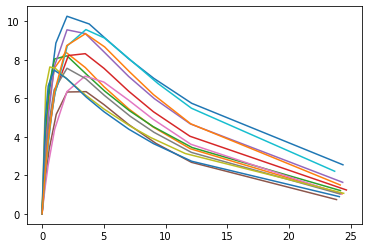

time-cwres


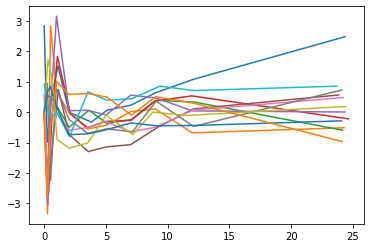

In [4]:
eval_result = model.evaluate()

print('time-pred')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for id, time_data in eval_result['times'].items() :
    y_pred = eval_result['preds'][id]
    ax.plot(time_data.to('cpu'), y_pred.detach().to('cpu').numpy())
plt.show()

print('time-cwres')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for id, time_data in eval_result['times'].items() :
    cwres_value = eval_result['cwress'][id]
    ax.plot(time_data.masked_select(eval_result['mdv_masks'][id]).to('cpu'), cwres_value.detach().to('cpu').numpy())
plt.show()

In [5]:
for k, v in eval_result.items():
    print(k)
    print(v)

total_loss
tensor(100.8446)
losses
{'1': 22.064922332763672, '2': 18.695892333984375, '3': -0.618046760559082, '4': 9.934192657470703, '5': 20.780223846435547, '6': 4.8540802001953125, '7': 2.2856273651123047, '8': 4.255135536193848, '9': 3.841615676879883, '10': 5.25465202331543, '11': -1.6014375686645508, '12': 11.097739219665527}
times
{'1': tensor([ 0.0000,  0.0000,  0.2500,  0.5700,  1.1200,  2.0200,  3.8200,  5.1000,
         7.0300,  9.0500, 12.1200, 24.3700]), '2': tensor([ 0.0000,  0.0000,  0.2700,  0.5200,  1.0000,  1.9200,  3.5000,  5.0200,
         7.0300,  9.0000, 12.0000, 24.3000]), '3': tensor([ 0.0000,  0.0000,  0.2700,  0.5800,  1.0200,  2.0200,  3.6200,  5.0800,
         7.0700,  9.0000, 12.1500, 24.1700]), '4': tensor([ 0.0000,  0.0000,  0.3500,  0.6000,  1.0700,  2.1300,  3.5000,  5.0200,
         7.0200,  9.0200, 11.9800, 24.6500]), '5': tensor([ 0.0000,  0.0000,  0.3000,  0.5200,  1.0000,  2.0200,  3.5000,  5.0200,
         7.0200,  9.1000, 12.0000, 24.3500]), '6'

In [6]:
cov_result = model.descale().covariance_step()
print(cov_result)

id 1
id 2
id 3
id 4
id 5
id 6
id 7
id 8
id 9
id 10
id 11
id 12
{'cov': tensor([[ 2.5877e-03, -8.8184e-03, -5.9718e-05,  2.3593e-03,  3.6296e-04,
          6.9235e-05,  1.0661e-04,  2.2093e-04,  4.1931e-04, -6.2157e-04,
          3.5055e-03],
        [ 2.9294e-02,  1.4832e-01, -1.2408e-03,  7.1456e-03, -2.5220e-03,
         -2.0792e-04, -1.3445e-05,  2.5837e-03,  3.9323e-03, -4.5787e-03,
          2.4434e-02],
        [-1.2894e-04, -4.7542e-04,  5.1788e-06,  7.1132e-06,  1.2158e-05,
          4.8695e-07, -4.7960e-06, -1.2099e-05, -1.9496e-05,  2.0551e-05,
         -1.2785e-04],
        [ 2.7395e-04, -7.5179e-03,  3.5561e-05,  2.8754e-02,  4.4668e-03,
          4.3609e-04, -1.1296e-03, -3.3772e-04, -4.3811e-04, -2.5026e-04,
         -2.2795e-03],
        [-9.3698e-05, -6.2316e-03,  1.9983e-05,  4.4743e-03,  9.2552e-04,
          1.1145e-04,  1.5628e-05, -5.9009e-05, -9.5215e-05, -5.1739e-05,
         -2.6728e-04],
        [ 3.9240e-06, -1.1718e-03,  2.7126e-06,  4.3845e-04,  1.1137e-04,


In [7]:
for (name, para) in model.named_parameters():
    print(name)
    print(para.detach().numpy())

pred_function_module.theta
[ 1.3399185  31.168056    0.08948982]
pred_function_module.etas.1
[-0.04096765 -0.16897704 -0.3002976 ]
pred_function_module.etas.2
[0.18039118 0.02229942 0.06789875]
pred_function_module.etas.3
[ 0.50579953  0.07526013 -0.02848029]
pred_function_module.etas.4
[-0.4096187  -0.0674737   0.03730416]
pred_function_module.etas.5
[-0.18085591 -0.15284213 -0.05291555]
pred_function_module.etas.6
[-0.42789078  0.15803385  0.19764061]
pred_function_module.etas.7
[-0.83646536 -0.01324016  0.14831679]
pred_function_module.etas.8
[0.02601678 0.11021063 0.04127861]
pred_function_module.etas.9
[ 1.4405334   0.22931142 -0.06563266]
pred_function_module.etas.10
[-0.63889396 -0.20311663 -0.13418204]
pred_function_module.etas.11
[0.97268736 0.2195403  0.04148459]
pred_function_module.etas.12
[-0.58832854 -0.20930023  0.04779918]
pred_function_module.epss.1
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
pred_functio

#Simulation

id 1


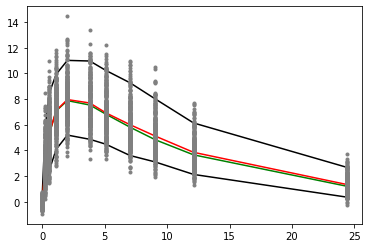

id 2


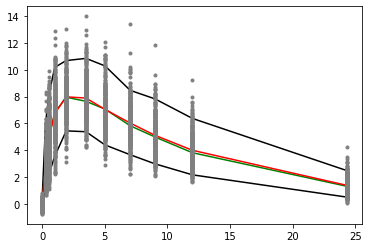

id 3


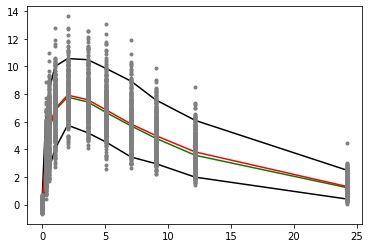

id 4


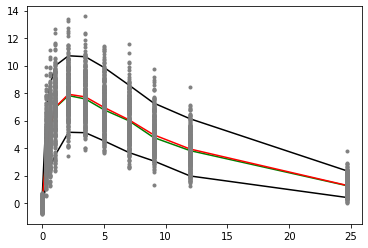

id 5


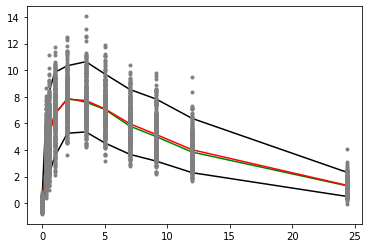

id 6


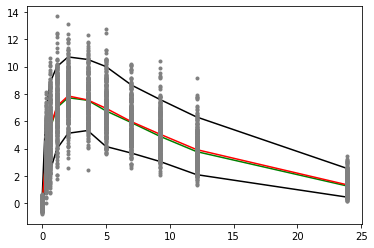

id 7


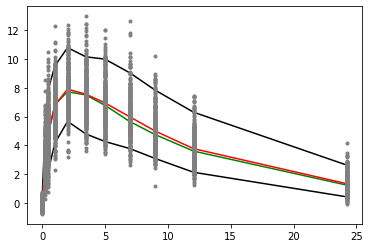

id 8


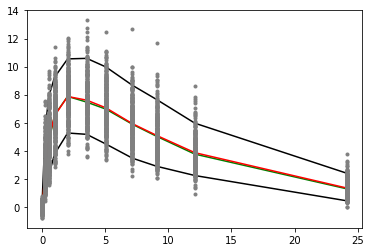

id 9


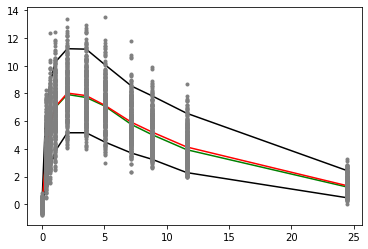

id 10


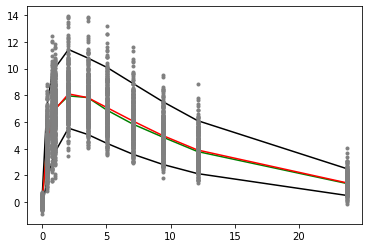

id 11


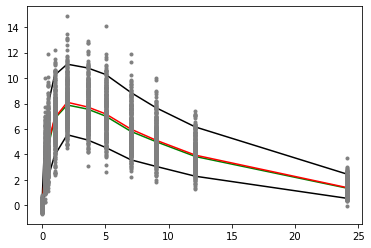

id 12


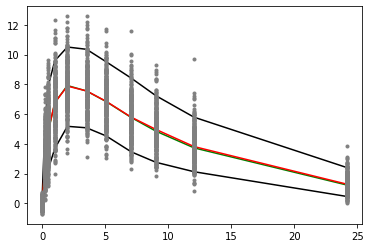

In [8]:
tc.manual_seed(42)
simulation_result = model.simulate(dataset, 300)

for id, time_data in simulation_result['times'].items() :
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    print('id', id)
    
    p95 = np.percentile(tc.stack(simulation_result['preds'][id]), 95, 0)
    p50 = np.percentile(tc.stack(simulation_result['preds'][id]), 50, 0)
    average = np.average(tc.stack(simulation_result['preds'][id]), 0)
    p5 = np.percentile(tc.stack(simulation_result['preds'][id]), 5, 0)
    
    ax.plot(time_data.to('cpu'), p95, color="black")
    ax.plot(time_data.to('cpu'), p50, color="green")
    ax.plot(time_data.to('cpu'), average, color="red")
    ax.plot(time_data.to('cpu'), p5, color="black")
    
    for y_pred in simulation_result['preds'][id] :
        ax.plot(time_data.to('cpu'), y_pred.detach().to('cpu'), marker='.', linestyle='', color='gray')
    plt.show()